In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikeras optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD

In [4]:
file_path = '/content/drive/My Drive/crypto_data/xrp_futures_4hour.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,open,high,low,close,volume
date,,,,,
2020-01-06 15:00:00,0.1970,0.2222,0.1970,0.2130,13996360.0
2020-01-06 19:00:00,0.2130,0.2180,0.2108,0.2124,17962735.0
2020-01-06 23:00:00,0.2124,0.2209,0.2115,0.2194,27389315.0
2020-01-07 03:00:00,0.2195,0.2259,0.2169,0.2226,32673808.9
2020-01-07 07:00:00,0.2227,0.2297,0.2183,0.2196,18665127.0
...,...,...,...,...,...
2024-08-11 11:00:00,0.5887,0.5930,0.5857,0.5911,75607112.6
2024-08-11 15:00:00,0.5911,0.5925,0.5732,0.5756,240120607.8
2024-08-11 19:00:00,0.5755,0.5762,0.5625,0.5663,232143297.2


In [5]:
datamodel = df.copy()
datamodel['return'] = datamodel['close'].pct_change().fillna(0)
for lag in [1, 2, 3, 4, 5]:
    datamodel[f'lag_{lag}'] = datamodel['return'].shift(lag)
datamodel['direction'] = np.where(datamodel['return'] > 0, 1, 0)
def hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

datamodel['hurst_exponent'] = datamodel['close'].rolling(window=100).apply(hurst_exponent, raw=True)

In [6]:
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
datamodel['EMA10'] = EMA(datamodel, 10)
datamodel['EMA30'] = EMA(datamodel, 30)
datamodel['EMA200'] = EMA(datamodel, 200)

def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
datamodel['ROC10'] = ROC(datamodel['close'], 10)
datamodel['ROC30'] = ROC(datamodel['close'], 30)

def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
datamodel['MOM10'] = MOM(datamodel['close'], 10)
datamodel['MOM30'] = MOM(datamodel['close'], 30)

def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
datamodel['RSI10'] = RSI(datamodel['close'], 10)
datamodel['RSI30'] = RSI(datamodel['close'], 30)
datamodel['RSI200'] = RSI(datamodel['close'], 200)

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

In [7]:
datamodel['%K10'] = STOK(datamodel['close'], datamodel['low'], datamodel['high'], 10)
datamodel['%D10'] = STOD(datamodel['close'], datamodel['low'], datamodel['high'], 10)
datamodel['%K30'] = STOK(datamodel['close'], datamodel['low'], datamodel['high'], 30)
datamodel['%D30'] = STOD(datamodel['close'], datamodel['low'], datamodel['high'], 30)
datamodel['%K200'] = STOK(datamodel['close'], datamodel['low'], datamodel['high'], 200)
datamodel['%D200'] = STOD(datamodel['close'], datamodel['low'], datamodel['high'], 200)
datamodel['MA21'] = MA(datamodel, 10)
datamodel['MA63'] = MA(datamodel, 30)
datamodel['MA252'] = MA(datamodel, 200)

In [8]:
datamodel = datamodel.fillna(0)
datamodel

,open,high,low,close,volume,return,lag_1,lag_2,lag_3,lag_4,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
date,,,,,,,,,,,,,,,,,,,,,
2020-01-06 15:00:00,0.1970,0.2222,0.1970,0.2130,13996360.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2020-01-06 19:00:00,0.2130,0.2180,0.2108,0.2124,17962735.0,-0.002817,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2020-01-06 23:00:00,0.2124,0.2209,0.2115,0.2194,27389315.0,0.032957,-0.002817,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2020-01-07 03:00:00,0.2195,0.2259,0.2169,0.2226,32673808.9,0.014585,0.032957,-0.002817,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2020-01-07 07:00:00,0.2227,0.2297,0.2183,0.2196,18665127.0,-0.013477,0.014585,0.032957,-0.002817,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-11 11:00:00,0.5887,0.5930,0.5857,0.5911,75607112.6,0.004247,0.008395,-0.012185,-0.010218,0.013754,...,51.785179,64.802632,56.681029,65.154504,63.365249,71.009491,69.856522,0.58760,0.571343,0.561634
2024-08-11 15:00:00,0.5911,0.5925,0.5732,0.5756,240120607.8,-0.026222,0.004247,0.008395,-0.012185,-0.010218,...,51.214955,9.027778,45.189847,54.963840,61.209730,63.980836,68.307101,0.58709,0.573760,0.562348
2024-08-11 19:00:00,0.5755,0.5762,0.5625,0.5663,232143297.2,-0.016157,-0.026222,0.004247,0.008395,-0.012185,...,50.877131,9.669211,27.833207,48.849441,56.322595,59.930314,64.973547,0.58571,0.575610,0.563009


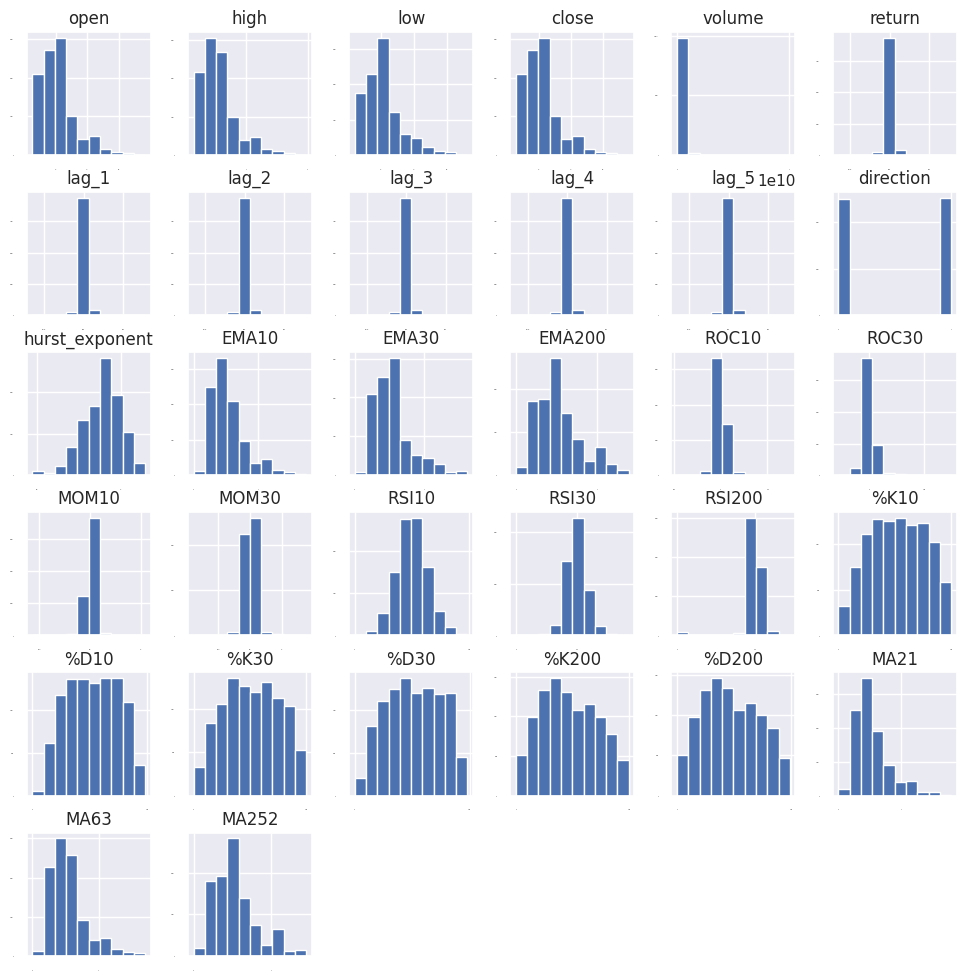

In [9]:
datamodel.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

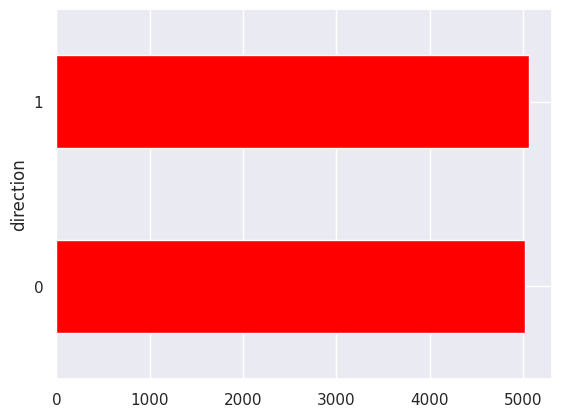

In [10]:
fig = plt.figure()
plot = datamodel.groupby(['direction']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

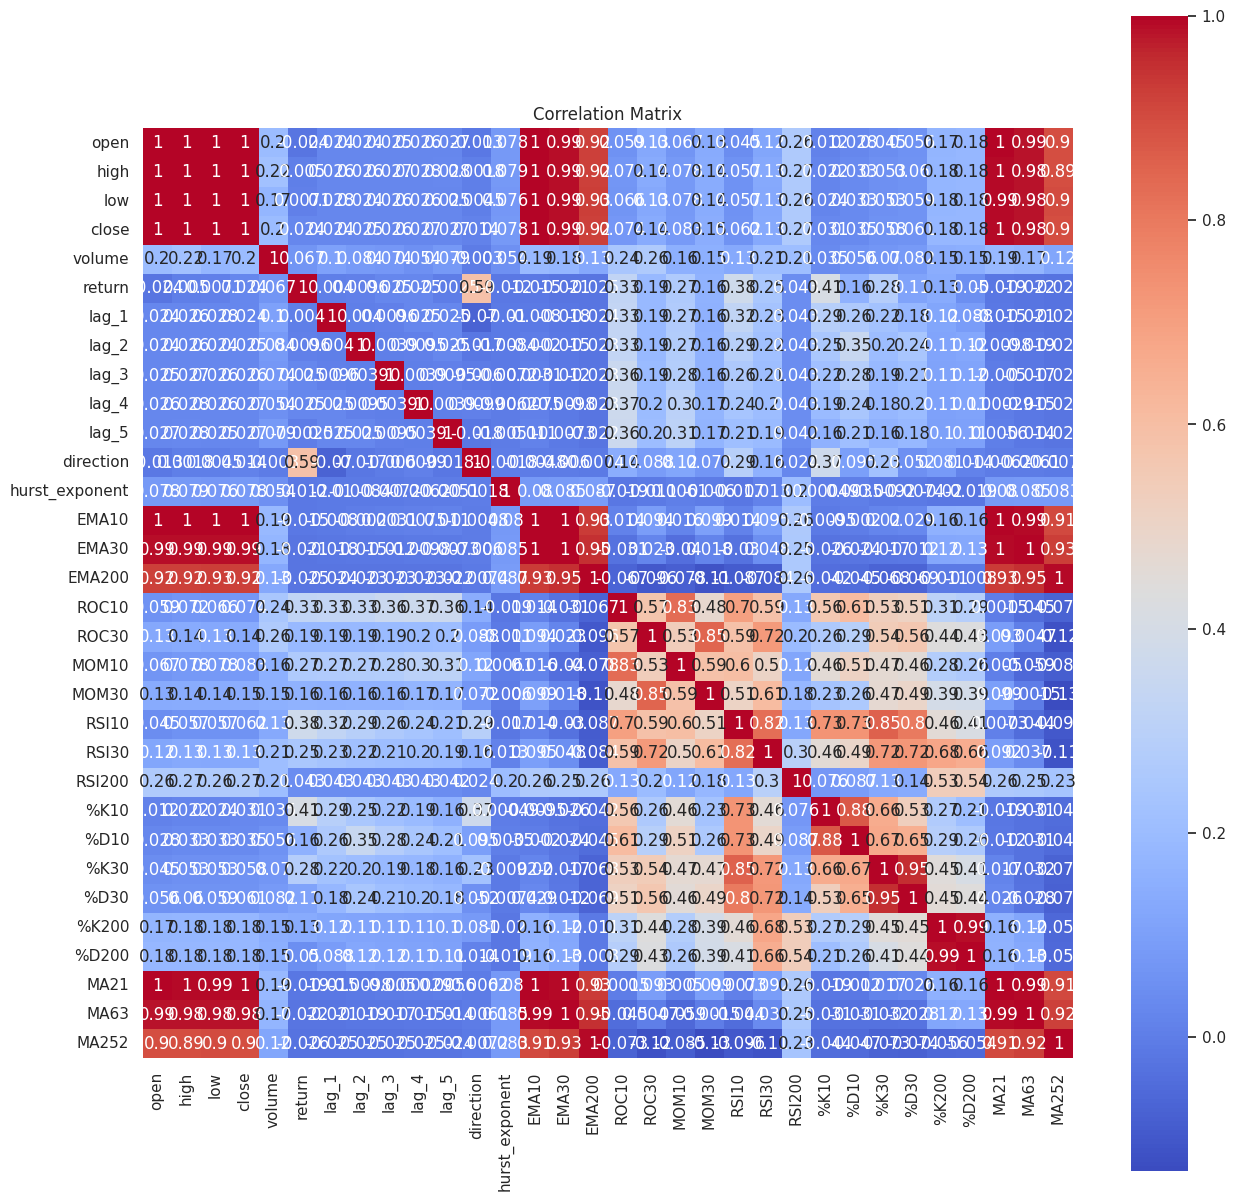

In [11]:
correlation = datamodel.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='coolwarm')

In [12]:
datamodel=datamodel.drop(['close', 'return', 'high','low','open', 'volume', 'EMA10' ,'EMA30', 'EMA200', 'MA21', 'MA63', 'MA252'], axis=1)
datamodel.head(5)

,lag_1,lag_2,lag_3,lag_4,lag_5,direction,hurst_exponent,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
date,,,,,,,,,,,,,,,,,,,,
2020-01-06 15:00:00,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06 19:00:00,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06 23:00:00,-0.002817,0.000000,0.000000,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07 03:00:00,0.032957,-0.002817,0.000000,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07 07:00:00,0.014585,0.032957,-0.002817,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
train = datamodel.iloc[:-2500]
test = datamodel.iloc[-2500:]

Y_train_full = train["direction"]
X_train_full = train.loc[:, ~train.columns.isin(['direction'])]

Y_test = test["direction"]
X_test = test.loc[:, ~test.columns.isin(['direction'])]

validation_size = int(len(X_train_full) * 0.2)
X_train = X_train_full.iloc[:-validation_size]
X_validation = X_train_full.iloc[-validation_size:]
Y_train = Y_train_full.iloc[:-validation_size]
Y_validation = Y_train_full.iloc[-validation_size:]

print(f"Training set: {X_train.shape}, Validation set: {X_validation.shape}")
print(f"Test set: {X_test.shape}")

Training set: (6063, 19), Validation set: (1515, 19)
Test set: (2500, 19)


In [14]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', MLPClassifier()))

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from joblib import parallel_backend

models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# Neural Network
models.append(('NN', MLPClassifier()))

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

ts_split = TimeSeriesSplit(n_splits=5)

results = []
names = []
threshold = 0.7

with parallel_backend('threading'):
    for name, model in models:
        cv_results = []
        for train_idx, val_idx in ts_split.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
            Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

            model.fit(X_train_fold, Y_train_fold)
            probas = model.predict_proba(X_val_fold)

            # Apply threshold for class 1
            preds = (probas[:, 1] >= threshold).astype(int)
            accuracy = accuracy_score(Y_val_fold, preds)
            cv_results.append(accuracy)

        results.append(cv_results)
        names.append(name)
        msg = f"{name}: {np.mean(cv_results):.4f} ({np.std(cv_results):.4f})"
        print(msg)


LR: 0.8297 (0.0177)
LDA: 0.8147 (0.0185)
KNN: 0.6550 (0.0235)
CART: 0.7549 (0.0249)
NB: 0.5850 (0.0178)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

NN: 0.8558 (0.0294)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AB: 0.4939 (0.0054)
GBM: 0.7879 (0.0146)
RF: 0.7160 (0.0390)


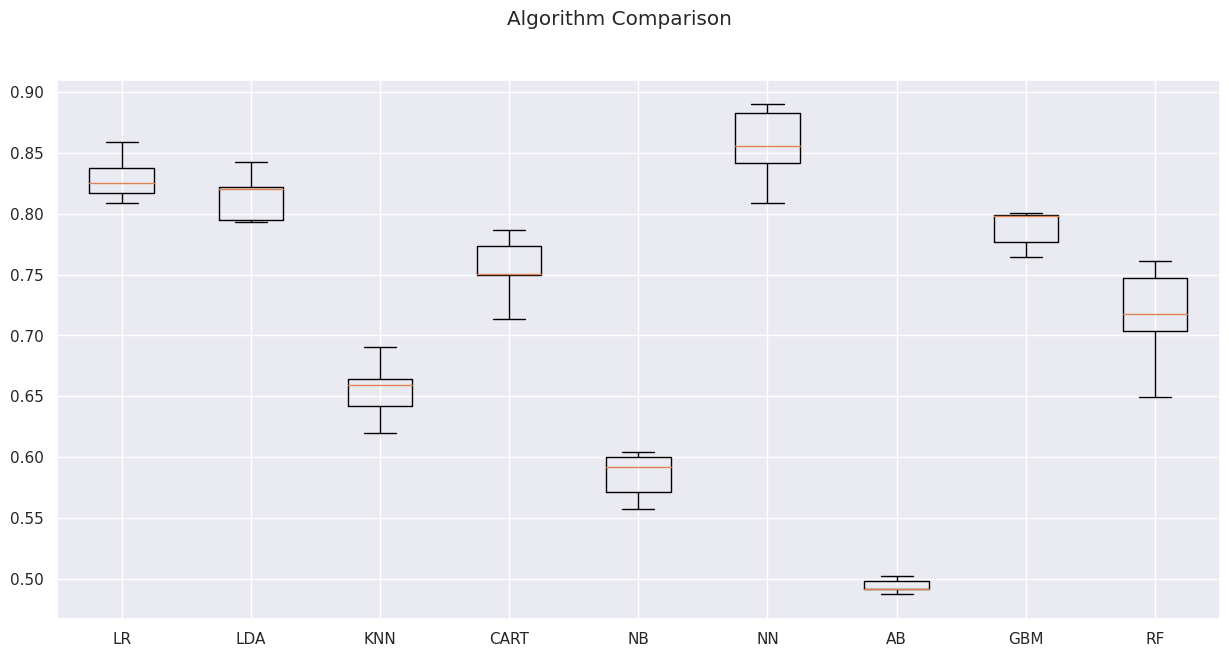

In [16]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,7)
plt.show()

In [17]:
import optuna
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore", category=ConvergenceWarning)

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

def objective(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear'])
    C = trial.suggest_float('C', 1e-3, 1e1, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 4000)
    threshold = trial.suggest_float('threshold', 0.5, 0.9)

    param = {
        'solver': solver,
        'C': C,
        'max_iter': max_iter
    }

    ts_split = TimeSeriesSplit(n_splits=5)
    accuracy_scores = []

    for train_idx, val_idx in ts_split.split(rescaledX):
        X_train_fold, X_val_fold = rescaledX[train_idx], rescaledX[val_idx]
        Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model = LogisticRegression(**param)
            model.fit(X_train_fold, Y_train_fold)

        probas = model.predict_proba(X_val_fold)
        preds = (probas[:, 1] >= threshold).astype(int)  # Apply the threshold
        accuracy = accuracy_score(Y_val_fold, preds)
        accuracy_scores.append(accuracy)

    return np.mean(accuracy_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best Accuracy: {study.best_value}")
print(f"Best Parameters: {study.best_params}")

[I 2024-08-15 01:40:40,759] A new study created in memory with name: no-name-acd92787-7706-4918-b25d-08dbe8de2cf9
[I 2024-08-15 01:40:40,817] Trial 0 finished with value: 0.7142574257425742 and parameters: {'solver': 'lbfgs', 'C': 0.017109063498173864, 'max_iter': 2435, 'threshold': 0.702954206458761}. Best is trial 0 with value: 0.7142574257425742.
[I 2024-08-15 01:40:40,917] Trial 1 finished with value: 0.8530693069306932 and parameters: {'solver': 'newton-cg', 'C': 8.755100547272553, 'max_iter': 2457, 'threshold': 0.6316838240171795}. Best is trial 1 with value: 0.8530693069306932.
[I 2024-08-15 01:40:41,019] Trial 2 finished with value: 0.8083168316831684 and parameters: {'solver': 'liblinear', 'C': 0.33911376266855814, 'max_iter': 1000, 'threshold': 0.7227336895381696}. Best is trial 1 with value: 0.8530693069306932.
[I 2024-08-15 01:40:41,081] Trial 3 finished with value: 0.7861386138613862 and parameters: {'solver': 'newton-cg', 'C': 0.07771172287505582, 'max_iter': 3058, 'thres

Best Accuracy: 0.8641584158415843
Best Parameters: {'solver': 'liblinear', 'C': 9.95280347433218, 'max_iter': 1951, 'threshold': 0.5327058440195239}


In [ ]:
study.best_params

{'solver': 'liblinear',
 'C': 9.648883005525388,
 'max_iter': 2973,
 'threshold': 0.5267764133113177}

In [18]:
import joblib

best_params = study.best_params
best_model = LogisticRegression(solver=study.best_params['solver'], C = study.best_params['C'], max_iter = study.best_params['max_iter'])
best_model.fit(rescaledX, Y_train)

model_filename = 'best_logistic_regression_model_futures_4hour.pkl'
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}.")

Model saved to best_logistic_regression_model_futures_4hour.pkl.


In [19]:
predictions = best_model.predict(X_validation_scaled)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8752475247524752
[[689  86]
 [103 637]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       775
           1       0.88      0.86      0.87       740

    accuracy                           0.88      1515
   macro avg       0.88      0.87      0.88      1515
weighted avg       0.88      0.88      0.88      1515



<Axes: xlabel='Predicted', ylabel='Actual'>

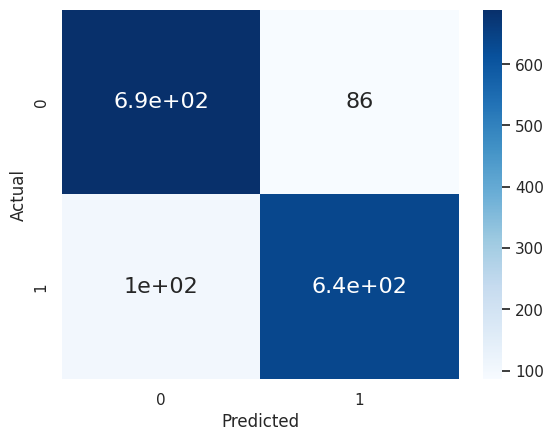

In [20]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

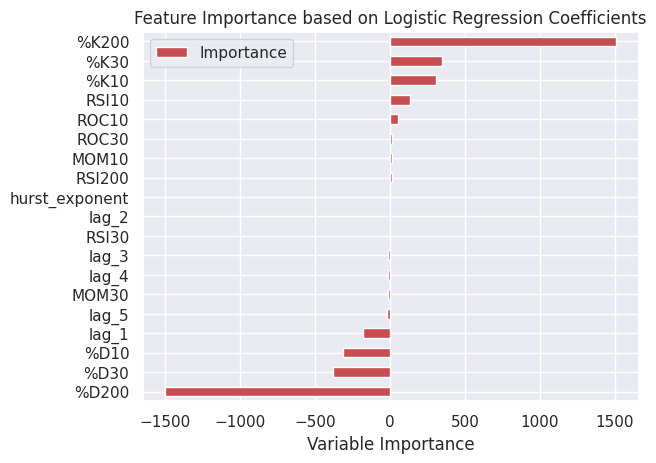

In [21]:
coefficients = best_model.coef_[0]

Importance = pd.DataFrame({'Importance': coefficients * 100}, index=X_train_full.columns)

Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.show()

In [22]:
X_train_scaled = scaler.transform(X_train)

train_predictions = best_model.predict(X_train_scaled)

train_accuracy = accuracy_score(Y_train, train_predictions)
train_confusion_matrix = confusion_matrix(Y_train, train_predictions)
train_classification_report = classification_report(Y_train, train_predictions)

print(f"Train Accuracy: {train_accuracy}")
print("Train Confusion Matrix:")
print(train_confusion_matrix)
print("Train Classification Report:")
print(train_classification_report)

Train Accuracy: 0.8756391225465942
Train Confusion Matrix:
[[2599  388]
 [ 366 2710]]
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2987
           1       0.87      0.88      0.88      3076

    accuracy                           0.88      6063
   macro avg       0.88      0.88      0.88      6063
weighted avg       0.88      0.88      0.88      6063



In [23]:
X_test_scaled = scaler.transform(X_test)

test_predictions = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(Y_test, test_predictions)
test_confusion_matrix = confusion_matrix(Y_test, test_predictions)
test_classification_report = classification_report(Y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy}")
print("Test Confusion Matrix:")
print(test_confusion_matrix)
print("Test Classification Report:")
print(test_classification_report)

Test Accuracy: 0.8604
Test Confusion Matrix:
[[1090  167]
 [ 182 1061]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1257
           1       0.86      0.85      0.86      1243

    accuracy                           0.86      2500
   macro avg       0.86      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500



<Axes: xlabel='Predicted', ylabel='Actual'>

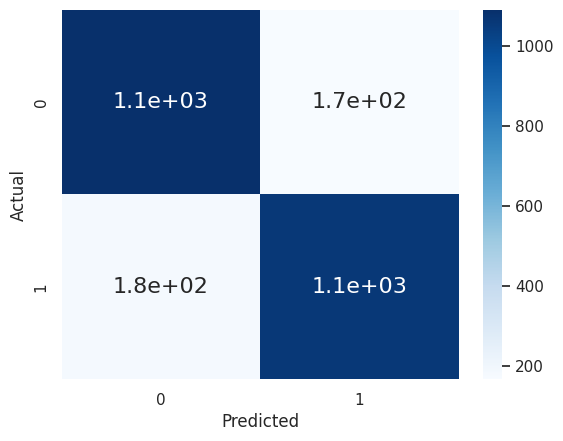

In [24]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, test_predictions), columns=np.unique(Y_test), index = np.unique(Y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [25]:
insample = df[:-4015]
outsample = df[-2500:]

In [26]:
outsample

,open,high,low,close,volume
date,,,,,
2023-06-22 15:00:00,0.5122,0.5128,0.4762,0.4931,460575078.6
2023-06-22 19:00:00,0.4931,0.5013,0.4848,0.4936,349595130.7
2023-06-22 23:00:00,0.4936,0.4990,0.4915,0.4987,158101466.7
2023-06-23 03:00:00,0.4988,0.4989,0.4922,0.4936,143145249.8
2023-06-23 07:00:00,0.4936,0.5010,0.4920,0.5000,128545934.4
...,...,...,...,...,...
2024-08-11 11:00:00,0.5887,0.5930,0.5857,0.5911,75607112.6
2024-08-11 15:00:00,0.5911,0.5925,0.5732,0.5756,240120607.8
2024-08-11 19:00:00,0.5755,0.5762,0.5625,0.5663,232143297.2


In [27]:
def perf_metrics(daily_pnl_series):
    sharpe = daily_pnl_series.mean() / daily_pnl_series.std() * np.sqrt(252)
    cum_ret = daily_pnl_series.cumsum()
    running_max = cum_ret.cummax()
    drawdown = running_max - cum_ret
    if cum_ret.max() == 0:
        max_dd = np.nan
    else:
        max_dd = (drawdown.max() / cum_ret.max()) * 100
    return sharpe, max_dd

In [34]:
trainbacktest = pd.DataFrame(index=insample.index)
trainbacktest['predictions'] = train_predictions
trainbacktest['close'] = insample['close']

trainbacktest['position'] = trainbacktest['predictions'].shift(4)
trainbacktest['position'] = np.where(
    trainbacktest['position'] >= study.best_params['threshold'], 1,
    np.where(trainbacktest['position'] < study.best_params['threshold'], -1, 0)
)

trainbacktest['pnl'] = trainbacktest['close'].diff() * trainbacktest['position'].shift(1)
trainbacktest['pnl'].fillna(0, inplace=True)

fee_rate = 0.0004  # 0.04% fee rate
trainbacktest['fee'] = np.where(trainbacktest['position'] != 1, trainbacktest['close'] * fee_rate, 0)
trainbacktest['pnl'] = trainbacktest['pnl'] - trainbacktest['fee']

initial_investment = 100

trainbacktest['cum_pnl'] = trainbacktest['pnl'].cumsum()
trainbacktest['equity'] = initial_investment + trainbacktest['cum_pnl']

trainbacktest

,predictions,close,position,pnl,cum_pnl,equity
date,,,,,,
2020-01-06 15:00:00,0,0.2130,0,0.0000,0.0000,100.0000
2020-01-06 19:00:00,0,0.2124,0,-0.0000,0.0000,100.0000
2020-01-06 23:00:00,0,0.2194,0,0.0000,0.0000,100.0000
2020-01-07 03:00:00,0,0.2226,0,0.0000,0.0000,100.0000
2020-01-07 07:00:00,0,0.2196,-1,-0.0000,0.0000,100.0000
...,...,...,...,...,...,...
2022-10-12 07:00:00,0,0.4858,-1,-0.0000,2.0960,102.0960
2022-10-12 11:00:00,1,0.4895,1,-0.0037,2.0923,102.0923
2022-10-12 15:00:00,1,0.4905,-1,0.0010,2.0933,102.0933


Sharpe Ratio: 0.6805911277046228
Maximum Drawdown (%): 65.23189201914782


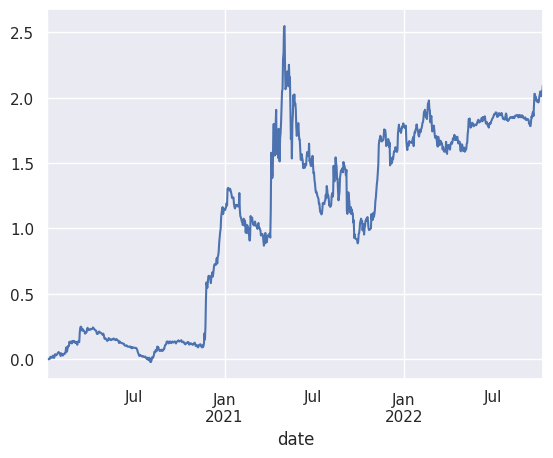

In [35]:
train_daily_pnl = trainbacktest['pnl'].resample('D').sum()
train_daily_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(train_daily_pnl)
print(f"Sharpe Ratio: {sharpe}")
print(f"Maximum Drawdown (%): {max_dd}")

In [32]:
backtestdata = pd.DataFrame(index=outsample.index)
backtestdata['predictions'] = test_predictions
backtestdata['close'] = outsample['close']

backtestdata['position'] = backtestdata['predictions'].shift(4)
backtestdata['position'] = np.where(
    backtestdata['position'] >= study.best_params['threshold'], 1,
    np.where(backtestdata['position'] < study.best_params['threshold'], -1, 0)
)

backtestdata['pnl'] = backtestdata['close'].diff() * backtestdata['position'].shift(1)
backtestdata['pnl'].fillna(0, inplace=True)

fee_rate = 0.0004
backtestdata['fee'] = np.where(backtestdata['position'] != 1, backtestdata['close'] * fee_rate, 0)
backtestdata['pnl'] = backtestdata['pnl'] - backtestdata['fee']
initial_investment = 100

backtestdata['cum_pnl'] = backtestdata['pnl'].cumsum()
backtestdata['equity'] = initial_investment + backtestdata['cum_pnl']

backtestdata

,predictions,close,position,pnl,cum_pnl,equity
date,,,,,,
2023-06-22 15:00:00,0,0.4931,0,0.0000,0.0000,100.0000
2023-06-22 19:00:00,0,0.4936,0,0.0000,0.0000,100.0000
2023-06-22 23:00:00,1,0.4987,0,0.0000,0.0000,100.0000
2023-06-23 03:00:00,0,0.4936,0,-0.0000,0.0000,100.0000
2023-06-23 07:00:00,1,0.5000,-1,0.0000,0.0000,100.0000
...,...,...,...,...,...,...
2024-08-11 11:00:00,1,0.5911,1,0.0025,0.7021,100.7021
2024-08-11 15:00:00,0,0.5756,-1,-0.0155,0.6866,100.6866
2024-08-11 19:00:00,0,0.5663,-1,0.0093,0.6959,100.6959


Sharpe Ratio: 1.1604011036952115
Maximum Drawdown (%): 26.96407422029224


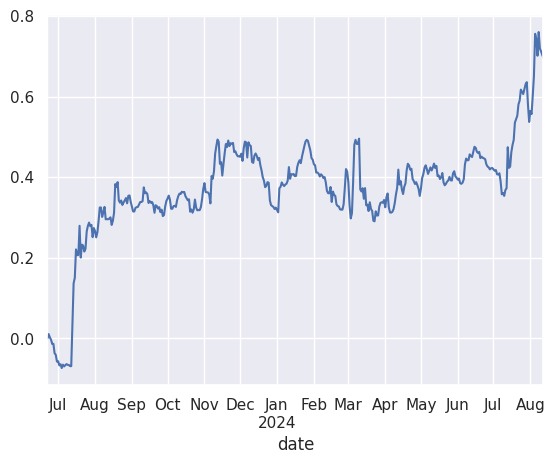

In [33]:
daily_pnl = backtestdata['pnl'].resample('D').sum()
daily_pnl.cumsum().plot()
sharpe, max_dd = perf_metrics(daily_pnl)
print(f"Sharpe Ratio: {sharpe}")
print(f"Maximum Drawdown (%): {max_dd}")

## Load trained model